In [18]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import normalized_mutual_info_score, mean_absolute_error, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data
wddf = pd.read_csv("weather_data.csv", index_col="Date")
pdddf = pd.read_csv("price_demand_data.csv")

# Setting maximum rows and columns to be displayed
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 245)

# Cleaning Column Names
pdddf.columns = ['region', 'settlement_date', 'total_demand', 'price_category']
wddf.columns = [x.lower() for x in wddf.columns]
wddf.columns = wddf.columns.str.strip()
wddf.columns = wddf.columns.str.replace(' ', '_')
wddf.columns = wddf.columns.str.replace('(', 'in_')
wddf.columns = wddf.columns.str.replace('°c', 'dc')
wddf.columns = wddf.columns.str.replace('km/h', 'kmph')
wddf.columns = wddf.columns.str.replace('%', 'pct')
wddf.columns = wddf.columns.str.strip(')')

# Cleaning Data
# Replacing Calm value by 1
wddf['3pm_wind_speed_in_kmph'].replace('Calm', '1', inplace=True)
wddf['9am_wind_speed_in_kmph'].replace('Calm', '1', inplace=True)

# Changing date to correct format
wddf.index = pd.to_datetime(wddf.index)

# Splitting column settlement_date and settlement_time
pdddf[['settlement_date', 'settlement_time']] = pdddf['settlement_date'].str.split(' ', expand=True)

# Assigning Numerical values to price_category just to find out the max
pdddf['price_category'] = pdddf['price_category'].replace({'LOW':1, 'MEDIUM': 2, 'HIGH':3, 'EXTREME':4})

# Grouping Price Demand data per day
dategrp = pdddf.groupby(['settlement_date'], sort=False)
# Aggregating energy's total demand and maximum price category on daily basis 
tempdf = dategrp[['total_demand', 'price_category']].agg({'total_demand':'max', 'price_category':'max'})



# Data frame with total_demand and price_category
df = pd.merge(wddf, tempdf, left_index=True, right_index=True, sort=False)
df['9am_wind_speed_in_kmph'] = df['9am_wind_speed_in_kmph'].astype(float)
df['3pm_wind_speed_in_kmph'] = df['3pm_wind_speed_in_kmph'].astype(float)
df['9am_cloud_amount_in_oktas'] = df['9am_cloud_amount_in_oktas'].astype(float)
df['3pm_relative_humidity_in_pct'] = df['3pm_relative_humidity_in_pct'].astype(float)



# Replacing null values to check performance with and without replacing null values
df['minimum_temperature_in_dc'].replace(np.nan, df['minimum_temperature_in_dc'].median(), inplace=True)
df['maximum_temperature_in_dc'].replace(np.nan, df['maximum_temperature_in_dc'].median(), inplace=True)
df['rainfall_in_mm'].replace(np.nan, df['rainfall_in_mm'].median(), inplace=True)
df['speed_of_maximum_wind_gust_in_kmph'].replace(np.nan, df['speed_of_maximum_wind_gust_in_kmph'].median(), inplace=True)
df['9am_temperature_in_dc'].replace(np.nan, df['9am_temperature_in_dc'].median(), inplace=True)
df['9am_relative_humidity_in_pct'].replace(np.nan, df['9am_relative_humidity_in_pct'].median(), inplace=True)
df['9am_wind_speed_in_kmph'].replace(np.nan, df['9am_wind_speed_in_kmph'].median(), inplace=True)
df['9am_msl_pressure_in_hpa'].replace(np.nan, df['9am_msl_pressure_in_hpa'].median(), inplace=True)
df['3pm_cloud_amount_in_oktas'].replace(np.nan, df['3pm_cloud_amount_in_oktas'].median(), inplace=True)
df['3pm_msl_pressure_in_hpa'].replace(np.nan, df['3pm_msl_pressure_in_hpa'].median(), inplace=True)

# Creating a Mean temperature column to check performance
df['mean_temp'] = df[['minimum_temperature_in_dc','maximum_temperature_in_dc','9am_temperature_in_dc', '3pm_temperature_in_dc']].mean(axis=1)

# Changing price_category back to normal values
df['price_category'] = df['price_category'].replace({1:'LOW', 2:'MEDIUM', 3:'HIGH', 4:'EXTREME'})
  
# # Dropping null values when running the model without replacing null values    
df.dropna(inplace=True)




In [41]:
# Correlation
dfcorr = df.corr()

dfcorr

,minimum_temperature_in_dc,maximum_temperature_in_dc,rainfall_in_mm,evaporation_in_mm,sunshine_in_hours,speed_of_maximum_wind_gust_in_kmph,9am_temperature_in_dc,9am_relative_humidity_in_pct,9am_cloud_amount_in_oktas,9am_wind_speed_in_kmph,9am_msl_pressure_in_hpa,3pm_temperature_in_dc,3pm_relative_humidity_in_pct,3pm_cloud_amount_in_oktas,3pm_wind_speed_in_kmph,3pm_msl_pressure_in_hpa,total_demand,mean_temp
minimum_temperature_in_dc,1.000000,0.707491,0.046841,0.655256,0.081676,0.056214,0.915725,-0.333651,0.206690,-0.003811,-0.326026,0.661837,-0.054982,0.054818,-0.023577,-0.278131,-0.488549,0.868364
maximum_temperature_in_dc,0.707491,1.000000,-0.122412,0.621330,0.468286,-0.055456,0.820007,-0.309296,-0.169024,-0.074763,-0.101662,0.966121,-0.456475,-0.241318,-0.029046,-0.178817,-0.291657,0.957882
rainfall_in_mm,0.046841,-0.122412,1.000000,-0.041847,-0.149117,0.044831,-0.017784,0.192440,0.072033,-0.071043,-0.138712,-0.122995,0.193617,0.111847,0.049467,-0.057514,-0.077924,-0.067778
evaporation_in_mm,0.655256,0.621330,-0.041847,1.000000,0.273256,0.158552,0.706067,-0.528487,0.014322,0.125419,-0.272186,0.560214,-0.208511,-0.097329,0.020897,-0.254203,-0.264008,0.681564
sunshine_in_hours,0.081676,0.468286,-0.149117,0.273256,1.000000,-0.058119,0.196796,-0.237505,-0.596661,0.004775,0.206771,0.487546,-0.550315,-0.718590,0.090647,0.132099,-0.139581,0.355416
speed_of_maximum_wind_gust_in_kmph,0.056214,-0.055456,0.044831,0.158552,-0.058119,1.000000,0.109502,-0.391711,0.025607,0.612004,-0.414617,-0.096490,-0.083259,0.130042,0.676151,-0.427160,0.080257,-0.005114
9am_temperature_in_dc,0.915725,0.820007,-0.017784,0.706067,0.196796,0.109502,1.000000,-0.467497,0.071705,0.037767,-0.285496,0.761946,-0.157088,-0.010683,0.022580,-0.277675,-0.391423,0.934664
9am_relative_humidity_in_pct,-0.333651,-0.309296,0.192440,-0.528487,-0.237505,-0.391711,-0.467497,1.000000,0.062991,-0.485133,0.142534,-0.261546,0.402212,0.035291,-0.229132,0.138717,0.103568,-0.365072
9am_cloud_amount_in_oktas,0.206690,-0.169024,0.072033,0.014322,-0.596661,0.025607,0.071705,0.062991,1.000000,-0.019797,-0.198555,-0.181595,0.424203,0.387080,0.001969,-0.121613,-0.167373,-0.040784
9am_wind_speed_in_kmph,-0.003811,-0.074763,-0.071043,0.125419,0.004775,0.612004,0.037767,-0.485133,-0.019797,1.000000,-0.252877,-0.088259,-0.188425,0.074857,0.400790,-0.261562,0.117655,-0.040311


<AxesSubplot:>

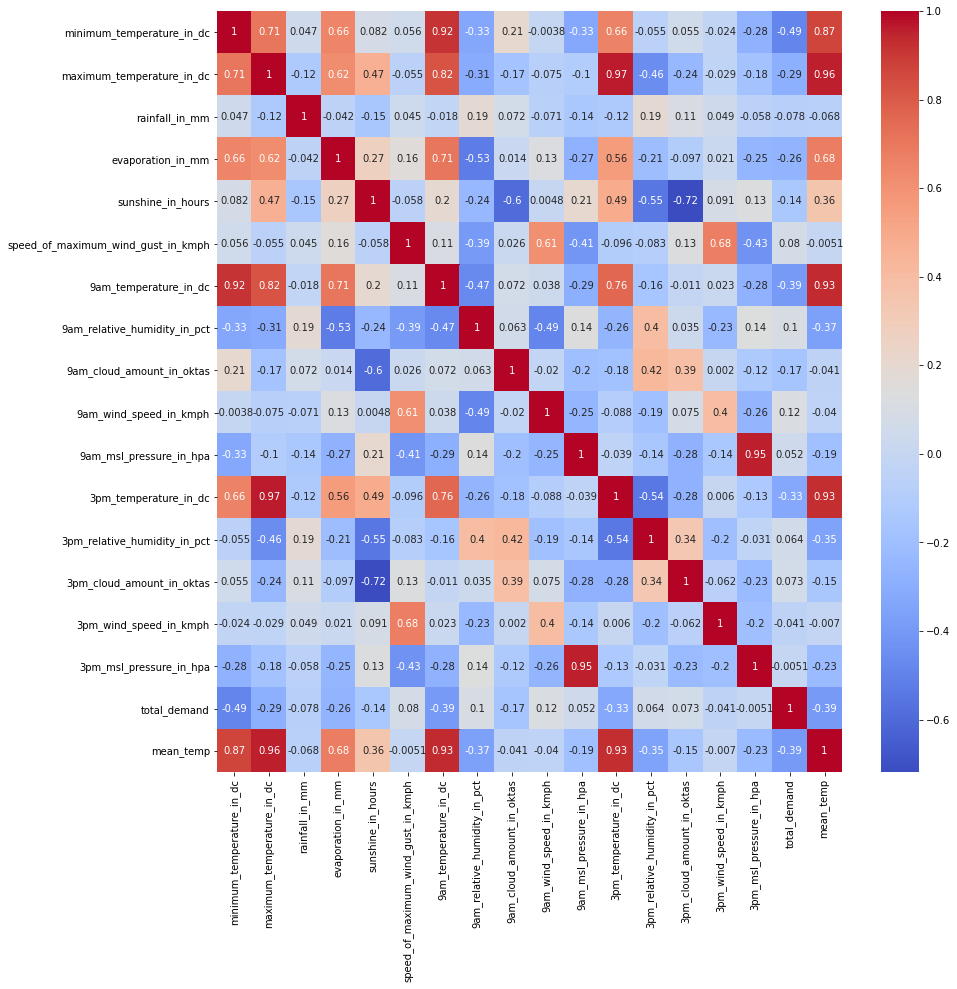

In [42]:
# Heatmap
plt.figure(figsize=(14,14))
sns.heatmap(dfcorr, annot=True, cmap='coolwarm')


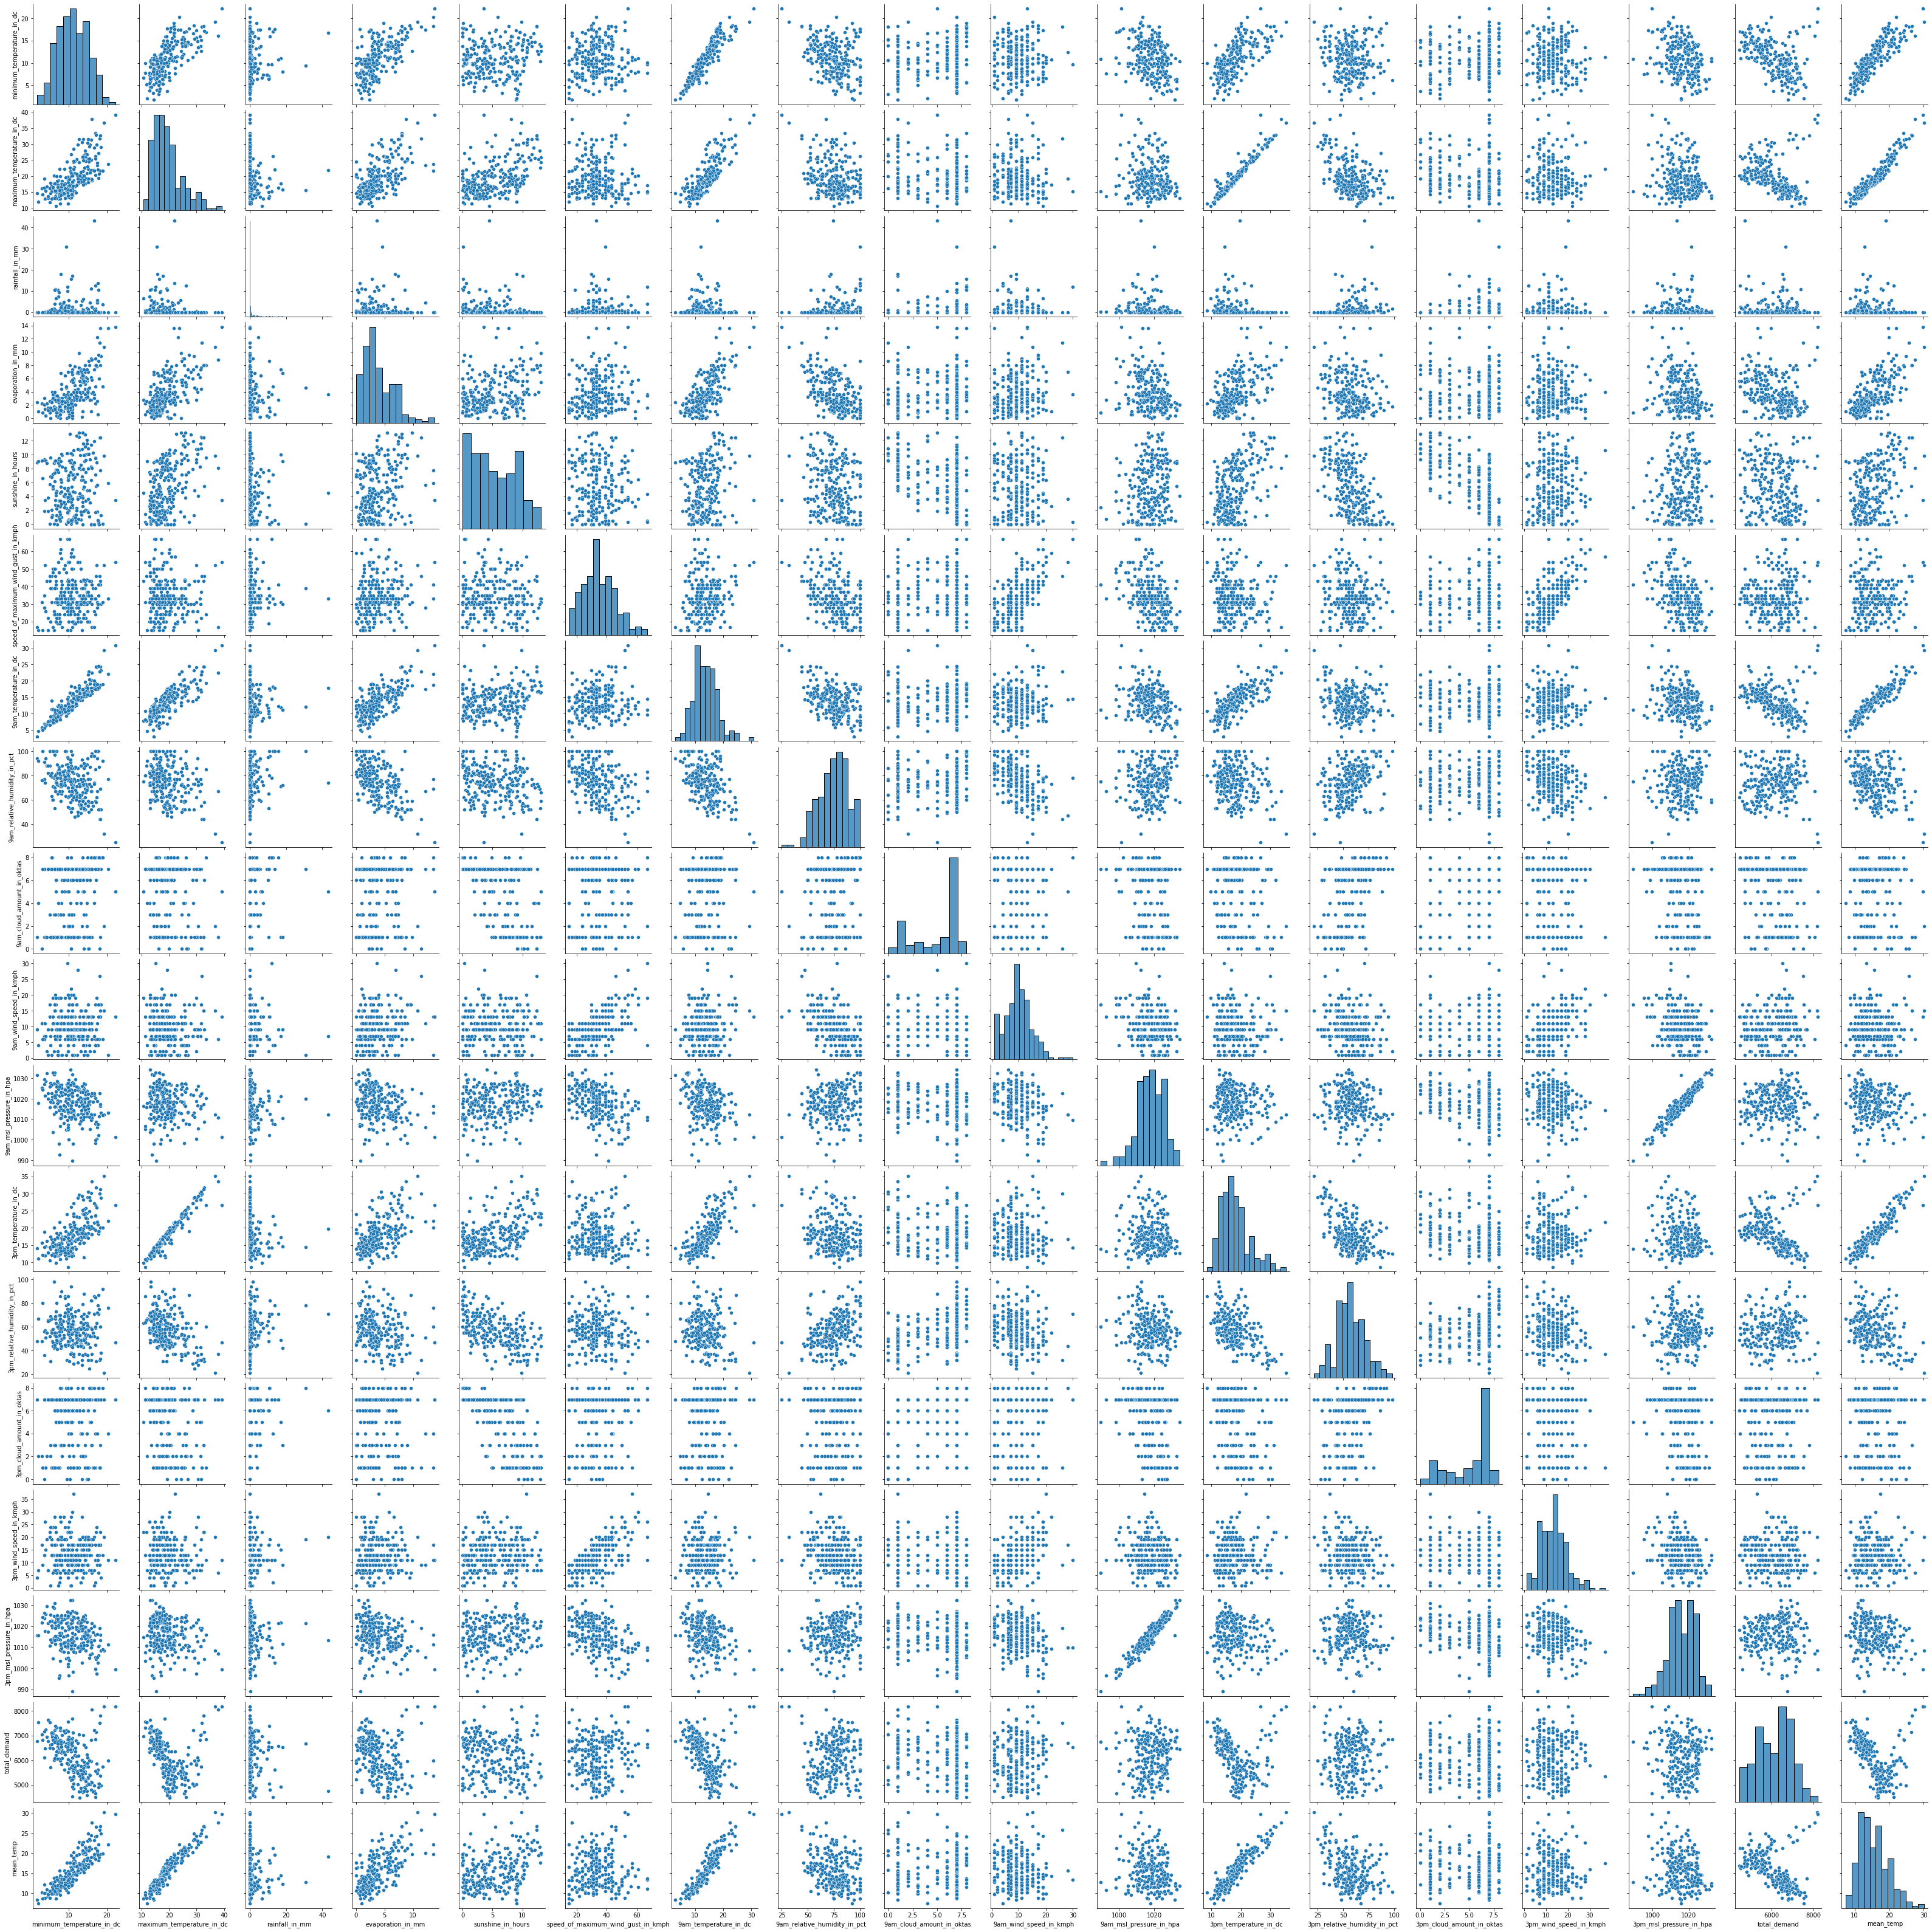

In [43]:
# Pairplot
sns.pairplot(df)

,minimum_temperature_in_dc,maximum_temperature_in_dc,rainfall_in_mm,evaporation_in_mm,sunshine_in_hours,direction_of_maximum_wind_gust,speed_of_maximum_wind_gust_in_kmph,time_of_maximum_wind_gust,9am_temperature_in_dc,9am_relative_humidity_in_pct,9am_cloud_amount_in_oktas,9am_wind_direction,9am_wind_speed_in_kmph,9am_msl_pressure_in_hpa,3pm_temperature_in_dc,3pm_relative_humidity_in_pct,3pm_cloud_amount_in_oktas,3pm_wind_direction,3pm_wind_speed_in_kmph,3pm_msl_pressure_in_hpa,total_demand,price_category,mean_temp,min_temp_binned,mean_temp_binned,max_temp_binned,rainfall_in_mm_binned,evaporation_in_mm_binned,sunshine_in_hours_binned,speed_of_maximum_wind_gust_in_kmph_binned,9am_temperature_in_dc_binned,9am_relative_humidity_in_pct_binned,9am_cloud_amount_in_oktas_binned,9am_wind_speed_in_kmph_binned,9am_msl_pressure_in_hpa_binned,3pm_temperature_in_dc_binned,3pm_relative_humidity_in_pct_binned,3pm_cloud_amount_in_oktas_binned,3pm_wind_speed_in_kmph_binned,3pm_msl_pressure_in_hpa_binned
2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,6.0,N,2.0,1018.8,28.1,43.0,5.0,E,13.0,1015.3,5019.64,LOW,23.20,"(15.367, 16.221]","(22.55, 23.497]","(29.667, 30.858]","(-0.0432, 10.8]","(2.3, 2.875]","(9.279, 9.825]","(30.167, 32.333]","(18.112, 19.275]","(75.0, 78.125]","(5.667, 6.0]","(0.971, 2.208]","(1017.512, 1019.367]","(27.442, 28.55]","(40.25, 43.458]","(4.667, 5.0]","(11.5, 13.0]","(1014.317, 1016.125]"
2021-02-01,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,7.0,NNW,17.0,1013.3,28.7,38.0,7.0,SW,4.0,1008.5,4964.35,LOW,24.85,"(17.929, 18.783]","(24.444, 25.391]","(28.475, 29.667]","(-0.0432, 10.8]","(9.2, 9.775]","(1.092, 1.637]","(28.0, 30.167]","(22.762, 23.925]","(50.0, 53.125]","(6.667, 7.0]","(16.708, 17.917]","(1011.95, 1013.804]","(28.55, 29.658]","(37.042, 40.25]","(6.667, 7.0]","(2.5, 4.0]","(1007.083, 1008.892]"
2021-03-01,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,8.0,WSW,4.0,1007.7,23.5,59.0,4.0,SSW,2.0,1005.2,4503.31,LOW,21.25,"(16.221, 17.075]","(20.656, 21.603]","(26.092, 27.283]","(10.8, 21.6]","(4.6, 5.175]","(7.096, 7.642]","(32.333, 34.5]","(18.112, 19.275]","(96.875, 100.0]","(7.667, 8.0]","(3.417, 4.625]","(1006.388, 1008.242]","(23.008, 24.117]","(56.292, 59.5]","(3.667, 4.0]","(0.964, 2.5]","(1003.467, 1005.275]"
2021-04-01,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,8.0,SSE,11.0,1010.0,18.2,82.0,8.0,SSW,17.0,1011.0,4764.18,LOW,17.25,"(15.367, 16.221]","(16.869, 17.816]","(17.75, 18.942]","(-0.0432, 10.8]","(3.45, 4.025]","(-0.0131, 0.546]","(38.833, 41.0]","(15.787, 16.95]","(96.875, 100.0]","(7.667, 8.0]","(10.667, 11.875]","(1008.242, 1010.096]","(17.467, 18.575]","(81.958, 85.167]","(7.667, 8.0]","(16.0, 17.5]","(1010.7, 1012.508]"
2021-05-01,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,8.0,SSE,13.0,1012.5,18.2,82.0,8.0,SSE,19.0,1013.3,4800.64,LOW,17.60,"(15.367, 16.221]","(16.869, 17.816]","(18.942, 20.133]","(10.8, 21.6]","(0.575, 1.15]","(-0.0131, 0.546]","(34.5, 36.667]","(16.95, 18.112]","(93.75, 96.875]","(7.667, 8.0]","(11.875, 13.083]","(1011.95, 1013.804]","(17.467, 18.575]","(81.958, 85.167]","(7.667, 8.0]","(17.5, 19.0]","(1012.508, 1014.317]"


Min Temp NMI: 0.26508180453782054
Mean Temp NMI: 0.28217384726634254
Max Temp NMI: 0.2870963467855953
rainfall_in_mm_binned NMI: 0.20754570826116017
evaporation_in_mm_binned NMI: 0.2253597653115594
sunshine_in_hours_binned NMI: 0.15351059264610653
speed_of_maximum_wind_gust_in_kmph_binned NMI: 0.16227982364456098
9am_temperature_in_dc_binned NMI: 0.24506722193800504
9am_relative_humidity_in_pct_binned NMI: 0.13199134457627992
9am_cloud_amount_in_oktas_binned NMI: 0.06085310980975765
9am_wind_speed_in_kmph_binned NMI: 0.06430913873260166
9am_msl_pressure_in_hpa_binned NMI: 0.13929945641077532
3pm_temperature_in_dc_binned NMI: 0.2706938287219163
3pm_relative_humidity_in_pct_binned NMI: 0.11522254746725417
3pm_cloud_amount_in_oktas_binned NMI: 0.08261554314320088
3pm_wind_speed_in_kmph_binned NMI: 0.09338799326612592
3pm_msl_pressure_in_hpa_binned NMI: 0.11002346318727786
direction_of_maximum_wind_gust NMI: 0.13356555345834606
9am_wind_direction NMI: 0.1515913152391215
3pm_wind_direction 

<AxesSubplot:>

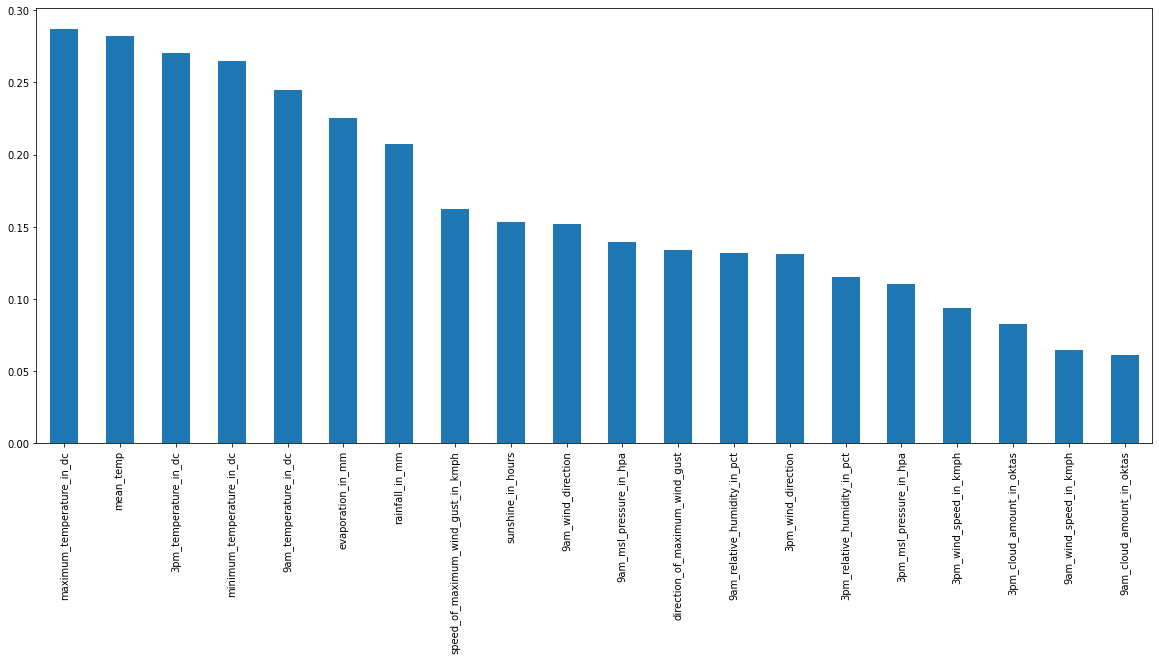

In [5]:
# Calculating Mutual Information for price_category

df['min_temp_binned'] = pd.cut(df['minimum_temperature_in_dc'], bins=24)
df['mean_temp_binned'] = pd.cut(df['mean_temp'], bins=24)
df['max_temp_binned'] = pd.cut(df['maximum_temperature_in_dc'], bins=24)
df['rainfall_in_mm_binned'] = pd.cut(df['rainfall_in_mm'], bins=4)
df['evaporation_in_mm_binned'] = pd.cut(df['evaporation_in_mm'], bins=24)
df['sunshine_in_hours_binned'] = pd.cut(df['sunshine_in_hours'], bins=24)
df['speed_of_maximum_wind_gust_in_kmph_binned'] = pd.cut(df['speed_of_maximum_wind_gust_in_kmph'], bins=24)
df['9am_temperature_in_dc_binned'] = pd.cut(df['9am_temperature_in_dc'], bins=24)
df['9am_relative_humidity_in_pct_binned'] = pd.cut(df['9am_relative_humidity_in_pct'], bins=24)
df['9am_cloud_amount_in_oktas_binned'] = pd.cut(df['9am_cloud_amount_in_oktas'], bins=24)
df['9am_wind_speed_in_kmph_binned'] = pd.cut(df['9am_wind_speed_in_kmph'], bins=24)
df['9am_msl_pressure_in_hpa_binned'] = pd.cut(df['9am_msl_pressure_in_hpa'], bins=24)
df['3pm_temperature_in_dc_binned'] = pd.cut(df['3pm_temperature_in_dc'], bins=24)
df['3pm_relative_humidity_in_pct_binned'] = pd.cut(df['3pm_relative_humidity_in_pct'], bins=24)
df['3pm_cloud_amount_in_oktas_binned'] = pd.cut(df['3pm_cloud_amount_in_oktas'], bins=24)
df['3pm_wind_speed_in_kmph_binned'] = pd.cut(df['3pm_wind_speed_in_kmph'], bins=24)
df['3pm_msl_pressure_in_hpa_binned'] = pd.cut(df['3pm_msl_pressure_in_hpa'], bins=24)

display(df.head())

min_nmi = normalized_mutual_info_score(df['min_temp_binned'], df['price_category'], average_method='min')
print('Min Temp NMI: ' + str(min_nmi))
mean_nmi = normalized_mutual_info_score(df['mean_temp_binned'], df['price_category'], average_method='min')
print('Mean Temp NMI: ' + str(mean_nmi))
max_nmi = normalized_mutual_info_score(df['max_temp_binned'], df['price_category'], average_method='min')
print('Max Temp NMI: ' + str(max_nmi))
rainfall_in_mm_binned_nmi = normalized_mutual_info_score(df['rainfall_in_mm_binned'], df['price_category'], average_method='min')
print('rainfall_in_mm_binned NMI: ' + str(rainfall_in_mm_binned_nmi))
evaporation_in_mm_binned_nmi = normalized_mutual_info_score(df['evaporation_in_mm_binned'], df['price_category'], average_method='min')
print('evaporation_in_mm_binned NMI: ' + str(evaporation_in_mm_binned_nmi))
sunshine_in_hours_binned_nmi = normalized_mutual_info_score(df['sunshine_in_hours_binned'], df['price_category'], average_method='min')
print('sunshine_in_hours_binned NMI: ' + str(sunshine_in_hours_binned_nmi))
speed_of_maximum_wind_gust_in_kmph_binned_nmi = normalized_mutual_info_score(df['speed_of_maximum_wind_gust_in_kmph_binned'], df['price_category'], average_method='min')
print('speed_of_maximum_wind_gust_in_kmph_binned NMI: ' + str(speed_of_maximum_wind_gust_in_kmph_binned_nmi))
_9am_temperature_in_dc_binned_nmi = normalized_mutual_info_score(df['9am_temperature_in_dc_binned'], df['price_category'], average_method='min')
print('9am_temperature_in_dc_binned NMI: ' + str(_9am_temperature_in_dc_binned_nmi))
am_relative_humidity_in_pct_binned_nmi = normalized_mutual_info_score(df['9am_relative_humidity_in_pct_binned'], df['price_category'], average_method='min')
print('9am_relative_humidity_in_pct_binned NMI: ' + str(am_relative_humidity_in_pct_binned_nmi))
am_cloud_amount_in_oktas_binned_nmi = normalized_mutual_info_score(df['9am_cloud_amount_in_oktas_binned'], df['price_category'], average_method='min')
print('9am_cloud_amount_in_oktas_binned NMI: ' + str(am_cloud_amount_in_oktas_binned_nmi))
am_wind_speed_in_kmph_binned_nmi = normalized_mutual_info_score(df['9am_wind_speed_in_kmph_binned'], df['price_category'], average_method='min')
print('9am_wind_speed_in_kmph_binned NMI: ' + str(am_wind_speed_in_kmph_binned_nmi))
am_msl_pressure_in_hpa_binned_nmi = normalized_mutual_info_score(df['9am_msl_pressure_in_hpa_binned'], df['price_category'], average_method='min')
print('9am_msl_pressure_in_hpa_binned NMI: ' + str(am_msl_pressure_in_hpa_binned_nmi))
pm_temperature_in_dc_binned_nmi = normalized_mutual_info_score(df['3pm_temperature_in_dc_binned'], df['price_category'], average_method='min')
print('3pm_temperature_in_dc_binned NMI: ' + str(pm_temperature_in_dc_binned_nmi))
pm_relative_humidity_in_pct_binned_nmi = normalized_mutual_info_score(df['3pm_relative_humidity_in_pct_binned'], df['price_category'], average_method='min')
print('3pm_relative_humidity_in_pct_binned NMI: ' + str(pm_relative_humidity_in_pct_binned_nmi))
pm_cloud_amount_in_oktas_binned_nmi = normalized_mutual_info_score(df['3pm_cloud_amount_in_oktas_binned'], df['price_category'], average_method='min')
print('3pm_cloud_amount_in_oktas_binned NMI: ' + str(pm_cloud_amount_in_oktas_binned_nmi))
pm_wind_speed_in_kmph_binned_nmi = normalized_mutual_info_score(df['3pm_wind_speed_in_kmph_binned'], df['price_category'], average_method='min')
print('3pm_wind_speed_in_kmph_binned NMI: ' + str(pm_wind_speed_in_kmph_binned_nmi))
pm_msl_pressure_in_hpa_binned_nmi = normalized_mutual_info_score(df['3pm_msl_pressure_in_hpa_binned'], df['price_category'], average_method='min')
print('3pm_msl_pressure_in_hpa_binned NMI: ' + str(pm_msl_pressure_in_hpa_binned_nmi))
direction_of_maximum_wind_gust_nmi = normalized_mutual_info_score(df['direction_of_maximum_wind_gust'], df['price_category'], average_method='min')
print('direction_of_maximum_wind_gust NMI: ' + str(direction_of_maximum_wind_gust_nmi))
am_wind_direction_nmi = normalized_mutual_info_score(df['9am_wind_direction'], df['price_category'], average_method='min')
print('9am_wind_direction NMI: ' + str(am_wind_direction_nmi))
pm_wind_direction_nmi = normalized_mutual_info_score(df['3pm_wind_direction'], df['price_category'], average_method='min')
print('3pm_wind_direction NMI: ' + str(pm_wind_direction_nmi))


mi = pd.Series({'minimum_temperature_in_dc':min_nmi, 'mean_temp':mean_nmi, 'maximum_temperature_in_dc':max_nmi, 
               'rainfall_in_mm':rainfall_in_mm_binned_nmi , 'evaporation_in_mm':evaporation_in_mm_binned_nmi,
               'sunshine_in_hours':sunshine_in_hours_binned_nmi, 
               'speed_of_maximum_wind_gust_in_kmph':speed_of_maximum_wind_gust_in_kmph_binned_nmi,
               '9am_temperature_in_dc':_9am_temperature_in_dc_binned_nmi, 
               '9am_relative_humidity_in_pct':am_relative_humidity_in_pct_binned_nmi, 
               '9am_cloud_amount_in_oktas':am_cloud_amount_in_oktas_binned_nmi,     
               '9am_wind_speed_in_kmph':am_wind_speed_in_kmph_binned_nmi, 
               '9am_msl_pressure_in_hpa':am_msl_pressure_in_hpa_binned_nmi,
               '3pm_temperature_in_dc':pm_temperature_in_dc_binned_nmi , 
               '3pm_relative_humidity_in_pct':pm_relative_humidity_in_pct_binned_nmi, 
               '3pm_cloud_amount_in_oktas':pm_cloud_amount_in_oktas_binned_nmi,
               '3pm_wind_speed_in_kmph':pm_wind_speed_in_kmph_binned_nmi, 
               '3pm_msl_pressure_in_hpa':pm_msl_pressure_in_hpa_binned_nmi,
               'direction_of_maximum_wind_gust':direction_of_maximum_wind_gust_nmi,
               '9am_wind_direction':am_wind_direction_nmi,
               '3pm_wind_direction':pm_wind_direction_nmi         
               })
mi.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [9]:
# k-NN Classification model 2


# Standardization of independent variables
knn_scaler = StandardScaler()
knn_scaler.fit(df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])
knn_scaler_df = knn_scaler.transform(df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])

# Assigning X and y
X = knn_scaler_df
y = df['price_category']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.13, random_state=5)

# Assigning k-NN algorithm to the model
knn_model = KNeighborsClassifier(n_neighbors=6)

# Fitting training data 
knn_model.fit(X_train, y_train)

# Predicting class by running k-NN on test data
knn_test_model = knn_model.predict(X_test)

# Checking predictions
y_pred = knn_model.predict(X_test)
        
# Displaying Results
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, knn_test_model),"\n")
print("Classification Report: \n", classification_report(y_test, knn_test_model))

Accuracy Score: 0.6875
Confusion Matrix: 
 [[8 2 0 0]
 [2 3 0 2]
 [0 0 4 1]
 [0 2 1 7]] 

Classification Report: 
               precision    recall  f1-score   support

     EXTREME       0.80      0.80      0.80        10
        HIGH       0.43      0.43      0.43         7
         LOW       0.80      0.80      0.80         5
      MEDIUM       0.70      0.70      0.70        10

    accuracy                           0.69        32
   macro avg       0.68      0.68      0.68        32
weighted avg       0.69      0.69      0.69        32



In [14]:
# Using k-NN model to predict a data point
min_temp = float(input("Please Enter Minimum Temperature in Celsius: "))
max_temp = float(input("Please Enter Maximum Temperature in Celsius: "))
rainfall = float(input("Please Enter Rainfall in mm:"))
evaporation = float(input("Please Enter Evaporation in mm: "))
data = [[min_temp, max_temp, rainfall, evaporation]]
target = knn_model.predict(data)
print(f"Maximum price category for provided weather data: {target[0]}")

Please Enter Minimum Temperature in Celsius:  15
Please Enter Maximum Temperature in Celsius:  16
Please Enter Rainfall in mm: 20
Please Enter Evaporation in mm:  7


Maximum price category for provided weather data: LOW


In [19]:
#one-hot encoding on non-numeric data

df = pd.get_dummies(df, columns=['direction_of_maximum_wind_gust','9am_wind_direction','3pm_wind_direction'])

In [16]:
# k-NN Classification k-NN model 3


# Standardization of independent variables
knn_scaler = StandardScaler()
knn_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
knn_scaler_df = knn_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = knn_scaler_df
y = df['price_category']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=69)

# Assigning k-NN algorithm to the model
knn_model = KNeighborsClassifier(n_neighbors=9)

#             #Perform PCA
#             pca = PCA(n_components=5)
#             X_train = pca.fit_transform(X_train)
#             X_test = pca.transform(X_test)

# Fitting training data 
knn_model.fit(X_train, y_train)

# Predicting class by running k-NN on test data
knn_test_model = knn_model.predict(X_test)

# Checking predictions
y_pred = knn_model.predict(X_test)
            
           
# Displaying Results
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, knn_test_model),"\n")
print("Classification Report: \n", classification_report(y_test, knn_test_model))

Accuracy Score: 0.75
Confusion Matrix: 
 [[6 0 0 0]
 [1 4 0 1]
 [0 0 3 1]
 [2 1 0 5]] 

Classification Report: 
               precision    recall  f1-score   support

     EXTREME       0.67      1.00      0.80         6
        HIGH       0.80      0.67      0.73         6
         LOW       1.00      0.75      0.86         4
      MEDIUM       0.71      0.62      0.67         8

    accuracy                           0.75        24
   macro avg       0.80      0.76      0.76        24
weighted avg       0.77      0.75      0.75        24



In [ ]:
# k-NN Classification, better k-NN model


# Standardization of independent variables
knn_scaler = StandardScaler()
knn_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
knn_scaler_df = knn_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = knn_scaler_df
y = df['price_category']

    
# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=69)

# Assigning k-NN algorithm to the model
knn_model = KNeighborsClassifier(n_neighbors=9)

# Fitting training data 
knn_model.fit(X_train, y_train)

# Predicting class by running k-NN on test data
knn_test_model = knn_model.predict(X_test)

# Checking predictions
y_pred = knn_model.predict(X_test)
            
# Displaying Results
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, knn_test_model),"\n")
print("Classification Report: \n", classification_report(y_test, knn_test_model))

In [54]:
# k-NN Classification, k-NN model 4


    
# Standardization of independent variables
knn_scaler = StandardScaler()
knn_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
knn_scaler_df = knn_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = knn_scaler_df
y = df['price_category']


# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=48)

# Assigning k-NN algorithm to the model
knn_model = KNeighborsClassifier(n_neighbors=4)


#Perform PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Fitting training data 
knn_model.fit(X_train, y_train)

# Predicting class by running k-NN on test data
knn_test_model = knn_model.predict(X_test)

# Checking predictions
y_pred = knn_model.predict(X_test)

# Displaying Results
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, knn_test_model),"\n")
print("Classification Report: \n", classification_report(y_test, knn_test_model))

Accuracy Score: 0.75
Confusion Matrix: 
 [[5 1 0 2]
 [1 5 1 0]
 [0 0 3 0]
 [0 0 1 5]] 

Classification Report: 
               precision    recall  f1-score   support

     EXTREME       0.83      0.62      0.71         8
        HIGH       0.83      0.71      0.77         7
         LOW       0.60      1.00      0.75         3
      MEDIUM       0.71      0.83      0.77         6

    accuracy                           0.75        24
   macro avg       0.75      0.79      0.75        24
weighted avg       0.77      0.75      0.75        24



In [11]:
# k fold cross validation k-NN model

data = df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc','9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1)
classlabel = df['price_category']


k=5
kf = KFold(n_splits=k, shuffle=True, random_state=21)
acc_score = []
for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]

    #Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)


    #Train k-nn classifier
    knn_model = KNeighborsClassifier(n_neighbors=7)
    knn_model.fit(X_train, y_train)

    #Predict result
    y_pred=knn_model.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))

print(acc_score)
#Display average of accuracy scores
avg_acc_score = sum(acc_score)/k
print(avg_acc_score)
        

[0.3958333333333333, 0.4583333333333333, 0.4583333333333333, 0.5625, 0.5416666666666666]
0.4833333333333333


In [9]:
# k fold cross validation with PCA k-NN model

data = df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1)
classlabel = df['price_category']


k=5
kf = KFold(n_splits=k, shuffle=True, random_state=5)
acc_score = []
for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]

    #Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)



    #Perform PCA
    pca = PCA(n_components=5)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    #Train k-nn classifier
    knn_model = KNeighborsClassifier(n_neighbors=11)
    knn_model.fit(X_train, y_train)

    #Predict result
    y_pred=knn_model.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))

print(acc_score)
#Display average of accuracy scores
avg_acc_score = sum(acc_score)/k
print(avg_acc_score)


[0.5833333333333334, 0.4791666666666667, 0.4583333333333333, 0.6666666666666666, 0.5]
0.5375


In [20]:

# Decision Tree model 1

# Standardization of independent variables
dt_scaler = StandardScaler()
dt_scaler.fit(df[['maximum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])
dt_scaler_df = dt_scaler.transform(df[['maximum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])

X = dt_scaler_df
y = df['price_category']

            
# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=33)

dtree = DecisionTreeClassifier(criterion="entropy",random_state=33, max_depth=2)
dtree.fit(X_train, y_train)

y_pred=dtree.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy Score:  0.6333333333333333
Confusion Matrix: 
 [[11  4  0  2]
 [ 3  5  0  5]
 [ 0  0  0  7]
 [ 1  0  0 22]] 

Classification Report: 
               precision    recall  f1-score   support

     EXTREME       0.73      0.65      0.69        17
        HIGH       0.56      0.38      0.45        13
         LOW       0.00      0.00      0.00         7
      MEDIUM       0.61      0.96      0.75        23

    accuracy                           0.63        60
   macro avg       0.47      0.50      0.47        60
weighted avg       0.56      0.63      0.58        60



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Using decision tree to predict a data point
mx_temp = float(input("Please Enter Maximum Temperature in celsius: "))
rain = float(input("Please Enter Rainfall in mm:"))
evap = float(input("Please Enter Evaporation in mm: "))
dta = [[mx_temp, rain, evap]]
trget = dtree.predict(dta)
print(f"Maximum price category for provided weather data: {trget[0]}")

Please Enter Maximum Temperature in celsius:  21.5
Please Enter Rainfall in mm: 3.5
Please Enter Evaporation in mm:  4.5


Maximum price category for provided weather data: MEDIUM


In [ ]:
# Decision Tree model


# Standardization of independent variables
dt_scaler = StandardScaler()
dt_scaler.fit(df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])
dt_scaler_df = dt_scaler.transform(df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']])

X = dt_scaler_df
y = df['price_category']
for i in range(100):
    for j in [0.2,0.3,0.33,0.4,0.35, 0.1, 0.15, 0.13, 0.17]:
        for k in range(1,10):
            
            
            # Splitting data for test and train
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=k)
            dtree.fit(X_train, y_train)

            y_pred=dtree.predict(X_test)
            if accuracy_score(y_test, y_pred)>0.7:
                print(i,j,k)
                print("Accuracy Score: ", accuracy_score(y_test, y_pred))
                print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
                print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# Decision Tree model


# Standardization of independent variables
dt_scaler = StandardScaler()
dt_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
dt_scaler_df = dt_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))

X = dt_scaler_df
y = df['price_category']
for i in range(100):
    for j in [0.2,0.3,0.33,0.4,0.35, 0.1, 0.15, 0.13, 0.17]:
        for k in range(1,10):
            
            
            # Splitting data for test and train
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=k)
            dtree.fit(X_train, y_train)

            y_pred=dtree.predict(X_test)
            if accuracy_score(y_test, y_pred)>0.7:
                print(i,j,k)
                print("Accuracy Score: ", accuracy_score(y_test, y_pred))
                print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
                print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# Decision Tree model


# Standardization of independent variables
dt_scaler = StandardScaler()
dt_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
dt_scaler_df = dt_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))

X = dt_scaler_df
y = df['price_category']
for i in range(100):
    for j in [0.2,0.3,0.33,0.4,0.35, 0.1, 0.15, 0.13, 0.17]:
        for k in range(1,10):
            
            
            # Splitting data for test and train
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)
            
            #Perform PCA
            pca = PCA(n_components=2)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=k)
            dtree.fit(X_train, y_train)

            y_pred=dtree.predict(X_test)
            if accuracy_score(y_test, y_pred)>0.7:
                print(i,j,k)
                print("Accuracy Score: ", accuracy_score(y_test, y_pred))
                print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")
                print("Classification Report: \n", classification_report(y_test, y_pred))

In [37]:
# Decision Tree model with k fold cross validation
data = df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1)
classlabel = df['price_category']

for i in range(100):
    for j in range(1,12):
        k=5
        kf = KFold(n_splits=k, shuffle=True, random_state=i)
        acc_score = []
        for train_index, test_index in kf.split(data):
            #Perform the split for this fold
            X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y_train, y_test = classlabel[train_index], classlabel[test_index]

            #Scale the data
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)



#             #Perform PCA
#             pca = PCA(n_components=2)
#             X_train = pca.fit_transform(X_train)
#             X_test = pca.transform(X_test)

            #Train Decision Tree classifier
            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=j)
            dtree.fit(X_train, y_train)

            #Predict result
            y_pred = dtree.predict(X_test)
            acc_score.append(accuracy_score(y_test, y_pred))

#         print(acc_score)
        #Display average of accuracy scores
        avg_acc_score = sum(acc_score)/k
#         print(avg_acc_score)
        if avg_acc_score>0.52:
            print(avg_acc_score, i,j)

0.5208333333333333 96 10


In [12]:
# Decision Tree model with k fold cross validation

data = df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1)
classlabel = df['price_category']


k=5
kf = KFold(n_splits=k, shuffle=True, random_state=96)
acc_score = []
for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]

    #Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)



    #             #Perform PCA
    #             pca = PCA(n_components=2)
    #             X_train = pca.fit_transform(X_train)
    #             X_test = pca.transform(X_test)

    #Train Decision Tree classifier
    dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=10)
    dtree.fit(X_train, y_train)

    #Predict result
    y_pred = dtree.predict(X_test)
    acc_score.append(accuracy_score(y_test, y_pred))

print(acc_score)
#Display average of accuracy scores
avg_acc_score = sum(acc_score)/k
print(avg_acc_score)



[0.5208333333333334, 0.3541666666666667, 0.5208333333333334, 0.625, 0.5]
0.5041666666666667


In [ ]:
# Decision Tree model with k fold cross validation with PCA
data = df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_msl_pressure_in_hpa', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1)
classlabel = df['price_category']

for i in range(100):
    for j in range(1,12):
        k=5
        kf = KFold(n_splits=k, shuffle=True, random_state=i)
        acc_score = []
        for train_index, test_index in kf.split(data):
            #Perform the split for this fold
            X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y_train, y_test = classlabel[train_index], classlabel[test_index]

            #Scale the data
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)



            #Perform PCA
            pca = PCA(n_components=2)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            #Train Decision Tree classifier
            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=j)
            dtree.fit(X_train, y_train)

            #Predict result
            y_pred = dtree.predict(X_test)
            acc_score.append(accuracy_score(y_test, y_pred))

#         print(acc_score)
        #Display average of accuracy scores
        avg_acc_score = sum(acc_score)/k
#         print(avg_acc_score)
        if avg_acc_score>0.47:
            print(avg_acc_score, i,j)

In [ ]:
# Decision Tree model with k fold cross validation

data = df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']]
classlabel = df['price_category']

for i in range(100):
    for j in range(1,12):
        k=5
        kf = KFold(n_splits=k, shuffle=True, random_state=i)
        acc_score = []
        for train_index, test_index in kf.split(data):
            #Perform the split for this fold
            X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y_train, y_test = classlabel[train_index], classlabel[test_index]

            #Scale the data
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)



#             #Perform PCA
#             pca = PCA(n_components=2)
#             X_train = pca.fit_transform(X_train)
#             X_test = pca.transform(X_test)

            #Train Decision Tree classifier
            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=j)
            dtree.fit(X_train, y_train)

            #Predict result
            y_pred = dtree.predict(X_test)
            acc_score.append(accuracy_score(y_test, y_pred))

#         print(acc_score)
        #Display average of accuracy scores
        avg_acc_score = sum(acc_score)/k
#         print(avg_acc_score)
        if avg_acc_score>0.45:
            print(avg_acc_score, i,j)

In [ ]:
# Decision Tree model with k fold cross validation

data = df[['maximum_temperature_in_dc', 'minimum_temperature_in_dc', 'rainfall_in_mm', 'evaporation_in_mm']]
classlabel = df['price_category']

for i in range(100):
    for j in range(1,12):
        k=5
        kf = KFold(n_splits=k, shuffle=True, random_state=i)
        acc_score = []
        for train_index, test_index in kf.split(data):
            #Perform the split for this fold
            X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y_train, y_test = classlabel[train_index], classlabel[test_index]

            #Scale the data
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)



            #Perform PCA
            pca = PCA(n_components=2)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            #Train Decision Tree classifier
            dtree = DecisionTreeClassifier(criterion="entropy",random_state=i, max_depth=j)
            dtree.fit(X_train, y_train)

            #Predict result
            y_pred = dtree.predict(X_test)
            acc_score.append(accuracy_score(y_test, y_pred))

#         print(acc_score)
        #Display average of accuracy scores
        avg_acc_score = sum(acc_score)/k
#         print(avg_acc_score)
        if avg_acc_score>0.45:
            print(avg_acc_score, i,j)

<AxesSubplot:>

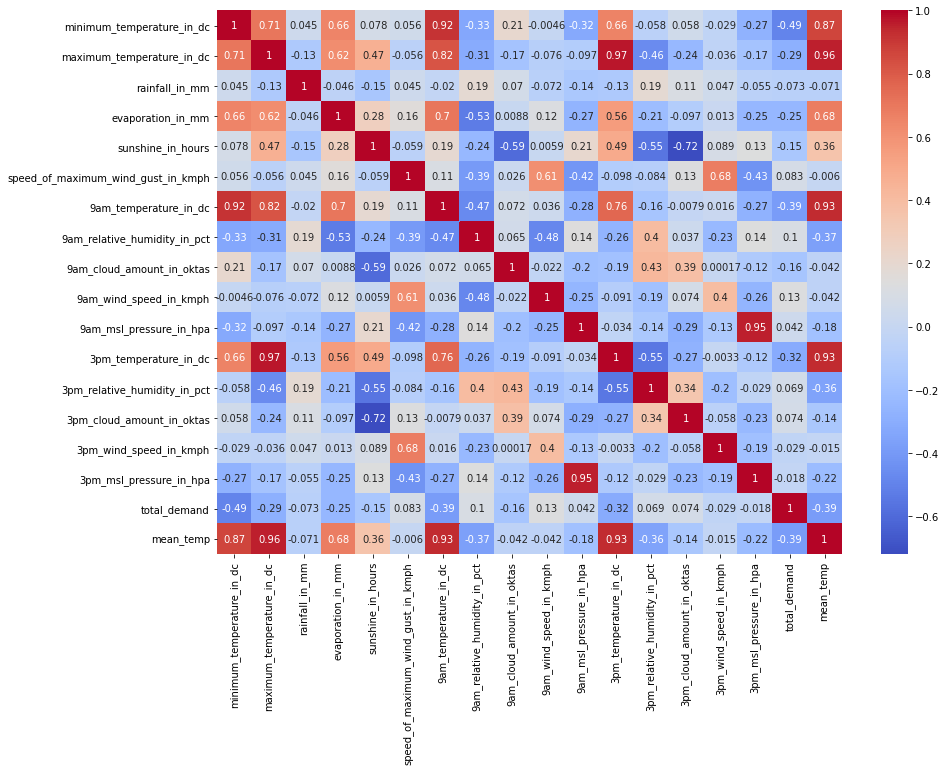

In [189]:
plt.figure(figsize=(14,10))
sns.heatmap(dfcorr, annot=True, cmap='coolwarm')

In [5]:
# Linear Regression Model 1

# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df[['minimum_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])
lr_scaler_df = lr_scaler.transform(df[['minimum_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=20)

# Assigning lenear regression algorithm to the model
lr_model = LinearRegression()

# Fitting training data 
lr_model.fit(X_train, y_train)


# Training data prediction error
mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
print(f"Training MAE: {mae_train:.2f}")

# Test data prediction error
mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
print(f"Test MAE: {mae_test:.2f}")

# coefficients
print('Coefficients: ', end = ' ')
print(lr_model.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lr_model.intercept_)
print('')

# R^2
r2_test = lr_model.score(X_test, y_test)
r2_train = lr_model.score(X_train, y_train)

print(f'Training Coefficient of determination: {r2_train:.2f}')
print(f'Test Coefficient of determination: {r2_test:.2f}')

Training MAE: 546.81
Test MAE: 324.57
Coefficients:  [-424.91603697  166.33808959 -248.02901183 -192.87959862]

Intercept:  6154.071363585921

Training Coefficient of determination: 0.25
Test Coefficient of determination: 0.59


In [49]:
# Using the linear regression model to predict a data point
min_temp = float(input("Please Enter Minimum Temperature in celsius: "))
evp = float(input("Please Enter Evaporation in mm: "))
sun_hr = float(input("Please Enter Sunshine in hours: "))
cloud = float(input("Please Enter 9 am Cloud amound: "))
lr_data = [[min_temp, evp, sun_hr, cloud]]
lr_target = lr_model.predict(lr_data)
print(f"Maximum daily energy usage for provided weather data: {abs(lr_target[0]):.2f}")

Please Enter Minimum Temperature in celsius:  16.5
Please Enter Evaporation in mm:  3.9
Please Enter Sunshine in hours:  10.5
Please Enter 9 am Cloud amound:  6.9


Maximum daily energy usage for provided weather data: 4143.50


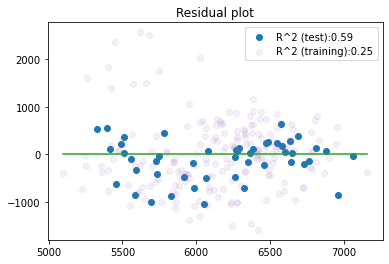

In [6]:

y_test_h = lr_model.predict(X_test)
y_train_h = lr_model.predict(X_train)

residual_train = [y - yh for y, yh in zip(y_train, y_train_h)]
residual_test = [y - yh for y, yh in zip(y_test, y_test_h)]

plt.scatter(y_test_h, residual_test, color='C0', label = 'R^2 (test):{0:.2f}'.format(r2_test))
plt.scatter(y_train_h, residual_train, color='C4', alpha = 0.1, label = 'R^2 (training):{0:.2f}'.format(r2_train))
plt.plot([min(y_train_h), max(y_train_h)], [0,0], color= 'C2')
plt.legend()
plt.title("Residual plot")
plt.show()


In [5]:
# Linear Regression Model 2.1

# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df[['minimum_temperature_in_dc', 'maximum_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])
lr_scaler_df = lr_scaler.transform(df[['minimum_temperature_in_dc', 'maximum_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=677)

# Assigning lenear regression algorithm to the model
lr_model = LinearRegression()


#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

# #Perform PCA
# pca = PCA(n_components=5)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Fitting training data 
lr_model.fit(X_train, y_train)


# Training data prediction error
mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))

r2_test = lr_model.score(X_test, y_test)
r2_train = lr_model.score(X_train, y_train)

        
print(f"Training MAE: {mae_train:.2f}")

# Test data prediction error

print(f"Test MAE: {mae_test:.2f}")

# coefficients
print('Coefficients: ', end = ' ')
print(lr_model.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lr_model.intercept_)
print('')

# R^2

print(f'Training Coefficient of determination: {r2_train:.2f}')
print(f'Test Coefficient of determination: {r2_test:.2f}')

Training MAE: 537.17
Test MAE: 301.46
Coefficients:  [-561.27194787  214.0822166   128.43171535 -269.95320697 -140.9971643 ]

Intercept:  6124.995041673501

Training Coefficient of determination: 0.28
Test Coefficient of determination: 0.70


In [6]:
# Linear Regression 3pm temperature 2.2

# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df[['minimum_temperature_in_dc', '3pm_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])
lr_scaler_df = lr_scaler.transform(df[['minimum_temperature_in_dc', '3pm_temperature_in_dc', 'evaporation_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas']])

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=677)

# Assigning lenear regression algorithm to the model
lr_model = LinearRegression()


#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)

# Fitting training data 
lr_model.fit(X_train, y_train)


# Training data prediction error
mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
r2_test = lr_model.score(X_test, y_test)
r2_train = lr_model.score(X_train, y_train)

        
           
print(f"Training MAE: {mae_train:.2f}")

# Test data prediction error

print(f"Test MAE: {mae_test:.2f}")

# coefficients
print('Coefficients: ', end = ' ')
print(lr_model.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lr_model.intercept_)
print('')



print(f'Training Coefficient of determination: {r2_train:.2f}')
print(f'Test Coefficient of determination: {r2_test:.2f}')

Training MAE: 535.17
Test MAE: 289.45
Coefficients:  [-485.69181858   90.73561101  154.19315646 -235.23278461 -156.64146607]

Intercept:  6125.924984234518

Training Coefficient of determination: 0.27
Test Coefficient of determination: 0.71


In [7]:
#All features after encoding model 3
#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Linear Regression

# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=981)

# Assigning lenear regression algorithm to the model
lr_model = LinearRegression()


#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)

# Fitting training data 
lr_model.fit(X_train, y_train)


# Training data prediction error
mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
r2_test = lr_model.score(X_test, y_test)
r2_train = lr_model.score(X_train, y_train)

       
print(f"Training MAE: {mae_train:.2f}")

# Test data prediction error

print(f"Test MAE: {mae_test:.2f}")

# coefficients
print('Coefficients: ', end = ' ')
print(lr_model.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lr_model.intercept_)
print('')



print(f'Training Coefficient of determination: {r2_train:.2f}')
print(f'Test Coefficient of determination: {r2_test:.2f}')




Training MAE: 408.59
Test MAE: 315.11
Coefficients:  [-4.35998241e+02  9.42152095e+01  4.00412466e+01  2.82720291e+01
 -7.85240406e+01  4.77374454e+01  2.34259184e+02 -5.67054156e+01
 -4.95781684e+01  1.04567626e+02  3.57318393e+02 -2.78909897e+02
  3.78351199e+01 -2.63513239e+01 -2.15812895e+02 -3.58427820e+02
 -8.89863686e+13 -1.25315850e+14 -4.16565195e+14 -1.08756396e+14
 -1.75715064e+14 -3.49531517e+14 -2.13342831e+14 -3.23735468e+14
 -1.39810227e+14 -1.95606790e+14 -3.78768960e+14 -1.64720248e+14
 -1.64720248e+14 -1.64720248e+14 -1.75715064e+14 -2.60795809e+14
 -1.01154649e+14 -7.16772476e+13 -1.23628093e+14 -4.92072042e+14
 -3.00438308e+14 -4.06209291e+14 -2.11402255e+14 -2.22354687e+14
 -2.22354687e+14 -1.58928324e+14 -3.00438308e+14 -1.58928324e+14
 -1.42451940e+14 -2.60795809e+14 -2.11402255e+14 -2.60795809e+14
 -6.87878414e+13 -3.10235647e+13 -3.10235647e+13 -4.37820633e+13
 -1.86357606e+14 -3.10235647e+13 -8.64533316e+13 -1.20136991e+14
 -8.10437874e+13 -1.73916837e+14 -6.1

In [ ]:
#All features after encoding and PCA
#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Linear Regression

# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']
for i in range(1000):
    for j in [0.1, 0.13, 0.15, 0.17, 0.25, 0.2, 0.3, 0.33, 0.4, 0.35]:
        # Splitting data for test and train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

        # Assigning lenear regression algorithm to the model
        lr_model = LinearRegression()

        
#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

        #Perform PCA
        pca = PCA(n_components=2)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        # Fitting training data 
        lr_model.fit(X_train, y_train)


        # Training data prediction error
        mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
        mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
        r2_test = lr_model.score(X_test, y_test)
        r2_train = lr_model.score(X_train, y_train)

        if (r2_test >= 0.5):
            print(i,j)
            print(f"Training MAE: {mae_train:.2f}")

            # Test data prediction error
            
            print(f"Test MAE: {mae_test:.2f}")

            # coefficients
            print('Coefficients: ', end = ' ')
            print(lr_model.coef_)
            print('')

            # intercept:
            print('Intercept: ', end = ' ')
            print(lr_model.intercept_)
            print('')

            

            print(f'Training Coefficient of determination: {r2_train:.2f}')
            print(f'Test Coefficient of determination: {r2_test:.2f}')




In [11]:
# less than 0.1

#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']
for i in range(1000):
    for j in [0.1, 0.13, 0.15, 0.17, 0.25, 0.2, 0.3, 0.33, 0.4, 0.35]:
        # Splitting data for test and train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

        # Assigning lenear regression algorithm to the model
        lr_model = LinearRegression()

        
#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)
        
        # Fitting training data 
        lr_model.fit(X_train, y_train)


        # Training data prediction error
        mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
        mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
        r2_test = lr_model.score(X_test, y_test)
        r2_train = lr_model.score(X_train, y_train)

        if (r2_test >= 0.7):
            print(i,j)
            print(f"Training MAE: {mae_train:.2f}")

            # Test data prediction error
            
            print(f"Test MAE: {mae_test:.2f}")

            # coefficients
            print('Coefficients: ', end = ' ')
            print(lr_model.coef_)
            print('')

            # intercept:
            print('Intercept: ', end = ' ')
            print(lr_model.intercept_)
            print('')

            

            print(f'Training Coefficient of determination: {r2_train:.2f}')
            print(f'Test Coefficient of determination: {r2_test:.2f}')




In [ ]:


# less than 0.2

#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'rainfall_in_mm', 'sunshine_in_hours', '9am_cloud_amount_in_oktas', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'sunshine_in_hours', '9am_cloud_amount_in_oktas', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']
for i in range(1000):
    for j in [0.1, 0.13, 0.15, 0.17, 0.25, 0.2, 0.3, 0.33, 0.4, 0.35]:
        # Splitting data for test and train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

        # Assigning lenear regression algorithm to the model
        lr_model = LinearRegression()

        
#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)
        
        # Fitting training data 
        lr_model.fit(X_train, y_train)


        # Training data prediction error
        mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
        mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
        r2_test = lr_model.score(X_test, y_test)
        r2_train = lr_model.score(X_train, y_train)

        if (r2_test >= 0.67):
            print(i,j)
            print(f"Training MAE: {mae_train:.2f}")

            # Test data prediction error
            
            print(f"Test MAE: {mae_test:.2f}")

            # coefficients
            print('Coefficients: ', end = ' ')
            print(lr_model.coef_)
            print('')

            # intercept:
            print('Intercept: ', end = ' ')
            print(lr_model.intercept_)
            print('')

            

            print(f'Training Coefficient of determination: {r2_train:.2f}')
            print(f'Test Coefficient of determination: {r2_test:.2f}')




In [8]:
# no 9am and max temp linear regression model 4

#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'maximum_temperature_in_dc' , '9am_temperature_in_dc', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', 'maximum_temperature_in_dc' , '9am_temperature_in_dc', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']

# Splitting data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=937)

# Assigning lenear regression algorithm to the model
lr_model = LinearRegression()

        
#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)
        
# Fitting training data 
lr_model.fit(X_train, y_train)


# Training data prediction error
mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
r2_test = lr_model.score(X_test, y_test)
r2_train = lr_model.score(X_train, y_train)

       
print(f"Training MAE: {mae_train:.2f}")

# Test data prediction error

print(f"Test MAE: {mae_test:.2f}")

# coefficients
print('Coefficients: ', end = ' ')
print(lr_model.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lr_model.intercept_)
print('')



print(f'Training Coefficient of determination: {r2_train:.2f}')
print(f'Test Coefficient of determination: {r2_test:.2f}')




Training MAE: 424.78
Test MAE: 357.19
Coefficients:  [-2.41224156e+02  1.62930958e+01 -7.63412735e+01 -6.50059157e+01
 -5.37075726e+01  6.73226177e+01 -1.22837710e+02  9.38903119e+13
  1.32221872e+14  4.39521656e+14  1.14749845e+14  1.85398532e+14
  3.68793824e+14  2.25099926e+14  3.41576182e+14  1.47515019e+14
  2.06386470e+14  3.99642511e+14  1.73797805e+14  1.73797805e+14
  1.73797805e+14  1.85398532e+14  1.80904875e+15  7.01674200e+14
  4.97199842e+14  8.57564575e+14  3.41333059e+15  2.08403481e+15
  2.81773090e+15  1.46642304e+15  1.54239621e+15  1.54239621e+15
  1.10242985e+15  2.08403481e+15  1.10242985e+15  9.88138974e+14
  1.80904875e+15  1.46642304e+15  1.80904875e+15 -2.93106697e+14
 -1.32192178e+14 -1.32192178e+14 -1.86556457e+14 -7.94074377e+14
 -1.32192178e+14 -3.68379789e+14 -5.11906694e+14 -3.45329587e+14
 -7.41063954e+14 -2.62719801e+14 -3.45329587e+14 -8.78529804e+14
 -4.80977816e+14 -4.64506091e+14 -4.47264939e+14 -4.10082019e+14]

Intercept:  6145.6155659387

Traini

In [ ]:
# no 9am and 3pm

#(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', '9am_cloud_amount_in_oktas', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '9am_wind_speed_in_kmph', '3pm_cloud_amount_in_oktas'], axis=1))
# Standardization of independent variables
lr_scaler = StandardScaler()
lr_scaler.fit(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp','3pm_temperature_in_dc', '9am_temperature_in_dc', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))
lr_scaler_df = lr_scaler.transform(df.drop(['time_of_maximum_wind_gust', 'price_category', 'total_demand', 'mean_temp', '3pm_temperature_in_dc', '9am_temperature_in_dc', 'rainfall_in_mm', 'speed_of_maximum_wind_gust_in_kmph', '9am_msl_pressure_in_hpa', '3pm_wind_speed_in_kmph', '3pm_relative_humidity_in_pct', '3pm_msl_pressure_in_hpa', '3pm_cloud_amount_in_oktas'], axis=1))

# Assigning X and y
X = lr_scaler_df
y = df['total_demand']
for i in range(1000):
    for j in [0.1, 0.13, 0.15, 0.17, 0.25, 0.2, 0.3, 0.33, 0.4, 0.35]:
        # Splitting data for test and train
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=j, random_state=i)

        # Assigning lenear regression algorithm to the model
        lr_model = LinearRegression()

        
#         #Impute missing values via mean imputation
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         X_train = imp.fit_transform(X_train)
#         X_test = imp.transform(X_test)

#         #Perform PCA
#         pca = PCA(n_components=2)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)
        
        # Fitting training data 
        lr_model.fit(X_train, y_train)


        # Training data prediction error
        mae_train = mean_absolute_error(y_train,lr_model.predict(X_train))
        mae_test = mean_absolute_error(y_test,lr_model.predict(X_test))
        r2_test = lr_model.score(X_test, y_test)
        r2_train = lr_model.score(X_train, y_train)

        if (r2_test >= 0.65):
            print(i,j)
            print(f"Training MAE: {mae_train:.2f}")

            # Test data prediction error
            
            print(f"Test MAE: {mae_test:.2f}")

            # coefficients
            print('Coefficients: ', end = ' ')
            print(lr_model.coef_)
            print('')

            # intercept:
            print('Intercept: ', end = ' ')
            print(lr_model.intercept_)
            print('')

            

            print(f'Training Coefficient of determination: {r2_train:.2f}')
            print(f'Test Coefficient of determination: {r2_test:.2f}')




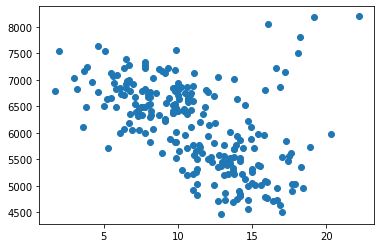

Pearson r is  -0.4927564706175161


In [86]:

plt.scatter(df['minimum_temperature_in_dc'],df['total_demand'])
plt.show()

print("Pearson r is ",df['minimum_temperature_in_dc'].corr(df['total_demand']))

 

In [89]:
# Calculating Mutual Information for total_demand

df['min_temp_binned'] = pd.cut(df['minimum_temperature_in_dc'], bins=24)
df['mean_temp_binned'] = pd.cut(df['mean_temp'], bins=24)
df['max_temp_binned'] = pd.cut(df['maximum_temperature_in_dc'], bins=24)
df['td_binned'] = pd.cut(df['total_demand'], bins=24)
display(df.head())

min_nmi = normalized_mutual_info_score(df['min_temp_binned'], df['td_binned'], average_method='min')
print('Min Temp NMI: ' + str(min_nmi))
mean_nmi = normalized_mutual_info_score(df['mean_temp_binned'], df['td_binned'], average_method='min')
print('Mean Temp NMI: ' + str(mean_nmi))
max_nmi = normalized_mutual_info_score(df['max_temp_binned'], df['td_binned'], average_method='min')
print('Max Temp NMI: ' + str(max_nmi))

,minimum_temperature_in_dc,maximum_temperature_in_dc,rainfall_in_mm,evaporation_in_mm,sunshine_in_hours,speed_of_maximum_wind_gust_in_kmph,time_of_maximum_wind_gust,9am_temperature_in_dc,9am_relative_humidity_in_pct,9am_cloud_amount_in_oktas,9am_wind_speed_in_kmph,9am_msl_pressure_in_hpa,3pm_temperature_in_dc,3pm_relative_humidity_in_pct,3pm_cloud_amount_in_oktas,3pm_wind_speed_in_kmph,3pm_msl_pressure_in_hpa,total_demand,price_category,mean_temp,direction_of_maximum_wind_gust_E,direction_of_maximum_wind_gust_ESE,direction_of_maximum_wind_gust_N,direction_of_maximum_wind_gust_NE,direction_of_maximum_wind_gust_NNE,...,9am_wind_direction_SW,9am_wind_direction_W,9am_wind_direction_WNW,9am_wind_direction_WSW,3pm_wind_direction_,3pm_wind_direction_E,3pm_wind_direction_ENE,3pm_wind_direction_ESE,3pm_wind_direction_N,3pm_wind_direction_NE,3pm_wind_direction_NNE,3pm_wind_direction_NNW,3pm_wind_direction_NW,3pm_wind_direction_S,3pm_wind_direction_SE,3pm_wind_direction_SSE,3pm_wind_direction_SSW,3pm_wind_direction_SW,3pm_wind_direction_W,3pm_wind_direction_WNW,3pm_wind_direction_WSW,min_temp_binned,mean_temp_binned,max_temp_binned,td_binned
2021-01-01,15.6,29.9,0.0,2.8,9.3,31.0,13:14,19.2,77.0,6.0,2.0,1018.8,28.1,43.0,5.0,13.0,1015.3,5019.64,LOW,23.20,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"(15.367, 16.221]","(22.55, 23.497]","(29.667, 30.858]","(4938.522, 5093.68]"
2021-02-01,18.4,29.0,0.0,9.4,1.3,30.0,8:22,23.3,52.0,7.0,17.0,1013.3,28.7,38.0,7.0,4.0,1008.5,4964.35,LOW,24.85,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"(17.929, 18.783]","(24.444, 25.391]","(28.475, 29.667]","(4938.522, 5093.68]"
2021-03-01,17.0,26.2,12.6,4.8,7.1,33.0,17:55,18.3,100.0,8.0,4.0,1007.7,23.5,59.0,4.0,2.0,1005.2,4503.31,LOW,21.25,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"(16.221, 17.075]","(20.656, 21.603]","(26.092, 27.283]","(4469.326, 4628.208]"
2021-04-01,16.0,18.6,2.6,3.8,0.0,41.0,16:03,16.2,98.0,8.0,11.0,1010.0,18.2,82.0,8.0,17.0,1011.0,4764.18,LOW,17.25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"(15.367, 16.221]","(16.869, 17.816]","(17.75, 18.942]","(4628.208, 4783.365]"
2021-05-01,15.9,19.1,11.2,1.0,0.0,35.0,11:02,17.2,96.0,8.0,13.0,1012.5,18.2,82.0,8.0,19.0,1013.3,4800.64,LOW,17.60,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"(15.367, 16.221]","(16.869, 17.816]","(18.942, 20.133]","(4783.365, 4938.522]"


Min Temp NMI: 0.34948301078183497
Mean Temp NMI: 0.38072802217762935
Max Temp NMI: 0.3798288925354834


In [10]:
# Calculating Mutual Information for total_demand with qcut

df['qmin_temp_binned'] = pd.qcut(df['minimum_temperature_in_dc'], q=25)
df['qmean_temp_binned'] = pd.qcut(df['mean_temp'], q=25)
df['qmax_temp_binned'] = pd.qcut(df['maximum_temperature_in_dc'], q=25)
df['qtd_binned'] = pd.qcut(df['total_demand'], q=25)
display(df.head())
qmin_nmi = normalized_mutual_info_score(df['qtd_binned'], df['qmin_temp_binned'], average_method='min')
print('Q_Min_NMI: ' + str(qmin_nmi))
qmean_nmi = normalized_mutual_info_score(df['qtd_binned'], df['qmean_temp_binned'], average_method='min')
print('Q_Mean_NMI: ' + str(qmean_nmi))
qmax_nmi = normalized_mutual_info_score(df['qtd_binned'], df['qmax_temp_binned'], average_method='min')
print('Q_Max_NMI: ' + str(qmax_nmi))

,minimum_temperature_in_dc,maximum_temperature_in_dc,rainfall_in_mm,evaporation_in_mm,sunshine_in_hours,direction_of_maximum_wind_gust,speed_of_maximum_wind_gust_in_kmph,time_of_maximum_wind_gust,9am_temperature_in_dc,9am_relative_humidity_in_pct,9am_cloud_amount_in_oktas,9am_wind_direction,9am_wind_speed_in_kmph,9am_msl_pressure_in_hpa,3pm_temperature_in_dc,...,3pm_cloud_amount_in_oktas,3pm_wind_direction,3pm_wind_speed_in_kmph,3pm_msl_pressure_in_hpa,total_demand,price_category,mean_temp,min_temp_binned,mean_temp_binned,max_temp_binned,td_binned,qmin_temp_binned,qtd_binned,qmean_temp_binned,qmax_temp_binned
1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,6,N,2,1018.8,28.1,...,5.0,E,13,1015.3,185853.37,1,23.20,"(15.367, 16.221]","(22.55, 23.497]","(29.667, 30.858]","(183858.279, 188869.177]","(15.0, 15.9]","(178847.37900000002, 191170.704]","(22.093, 24.163]","(28.716, 31.372]"
2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,7,NNW,17,1013.3,28.7,...,7.0,SW,4,1008.5,197990.13,1,24.85,"(17.929, 18.783]","(24.444, 25.391]","(28.475, 29.667]","(193880.076, 198890.975]","(17.7, 22.2]","(191170.704, 198311.39]","(24.163, 30.125]","(28.716, 31.372]"
3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,8,WSW,4,1007.7,23.5,...,4.0,SSW,2,1005.2,188742.96,1,21.25,"(16.221, 17.075]","(20.656, 21.603]","(26.092, 27.283]","(183858.279, 188869.177]","(16.844, 17.7]","(178847.37900000002, 191170.704]","(20.664, 22.093]","(26.008, 28.716]"
4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,8,SSE,11,1010.0,18.2,...,8.0,SSW,17,1011.0,199281.07,1,17.25,"(15.367, 16.221]","(16.869, 17.816]","(17.75, 18.942]","(198890.975, 203901.874]","(15.9, 16.844]","(198311.39, 202564.53]","(17.172, 17.563]","(18.532, 19.196]"
5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,8,SSE,13,1012.5,18.2,...,8.0,SSE,19,1013.3,207680.91,1,17.60,"(15.367, 16.221]","(16.869, 17.816]","(18.942, 20.133]","(203901.874, 208912.772]","(15.0, 15.9]","(207642.731, 212079.746]","(17.563, 18.258]","(18.532, 19.196]"


Q_Min_NMI: 0.3673467469466252
Q_Mean_NMI: 0.41970601771581684
Q_Max_NMI: 0.4019614565451906


In [106]:
# New DataFrame for Chi2 Calculation
cdf = df[['direction_of_maximum_wind_gust', '9am_wind_direction', '3pm_wind_direction', 'price_category']]
cdf.head()

,direction_of_maximum_wind_gust,9am_wind_direction,3pm_wind_direction,price_category
2021-01-01,NNE,N,E,LOW
2021-02-01,NNW,NNW,SW,LOW
2021-03-01,WSW,WSW,SSW,LOW
2021-04-01,SSE,SSE,SSW,LOW
2021-05-01,SSE,SSE,SSE,LOW


In [89]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2021-01-01 to 2021-08-31
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   direction_of_maximum_wind_gust  240 non-null    object
 1   9am_wind_direction              240 non-null    object
 2   3pm_wind_direction              240 non-null    object
dtypes: object(3)
memory usage: 7.5+ KB


In [107]:
# Converting Categorical variables to numerical for Chi2

dwg = {j:i for i, j in enumerate(cdf['direction_of_maximum_wind_gust'].unique(), 0)}
cdf['direction_of_maximum_wind_gust'] = cdf['direction_of_maximum_wind_gust'].map(dwg)
nwd = {j:i for i, j in enumerate(cdf['9am_wind_direction'].unique(), 0)}
cdf['9am_wind_direction'] = cdf['9am_wind_direction'].map(nwd)
twd = {j:i for i, j in enumerate(cdf['3pm_wind_direction'].unique(), 0)}
cdf['3pm_wind_direction'] = cdf['3pm_wind_direction'].map(twd)
pc = {j:i for i, j in enumerate(cdf['price_category'].unique(), 0)}
cdf['price_category'] = cdf['price_category'].map(pc)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [108]:
cdf.head()

,direction_of_maximum_wind_gust,9am_wind_direction,3pm_wind_direction,price_category
2021-01-01,0,0,0,0
2021-02-01,1,1,1,0
2021-03-01,2,2,2,0
2021-04-01,3,3,2,0
2021-05-01,3,3,3,0


In [110]:
#chi2
X = cdf.drop('price_category', axis=1)
y = cdf['price_category']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [113]:
#chi2 calculation
from sklearn.feature_selection import chi2
f_p = chi2(X_train, y_train)


In [114]:
f_p

(array([10.81786733, 10.88432007, 14.78217416]),
 array([0.01275263, 0.01236813, 0.00201258]))